In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
sys.path.append('..')
sys.path.append('../..')
from odeSysBuilder import panda_ode_solver
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
nx = 14

In [3]:
from casadi import *
from workspace.Common.M_matrix import M_panda
from workspace.Common.C_matrix import C_panda
from workspace.Common.G_vector import G_panda
from workspace.Common.utils import get_dyna

param = get_dyna()

q_dq = casadi.SX.sym("q_dq", 14)
M = M_panda(param, q_dq[:7], cos, sin)
C = C_panda(param, q_dq[:7], q_dq[7:], cos, sin)
G = G_panda(param, q_dq[:7], cos, sin)

M = vertcat(*M)
G = vertcat(*G)
C = vertcat(*C)

M = casadi.reshape(M, 7, 7)
G = casadi.reshape(G, 7, 1)
C = casadi.reshape(C, 7, 7)

G = casadi.simplify(G)
C = casadi.simplify(C)
M = casadi.simplify(M)

# 7 times faster than python function, C++ backend.
M_func = Function('M', [q_dq[:7]], [M])
C_func = Function('M', [q_dq], [C])
G_func = Function('M', [q_dq[:7]], [G])

ode_solver = panda_ode_solver()

### There is a refrence traj folder for evaluation

sampling frequency is: 100 Hz


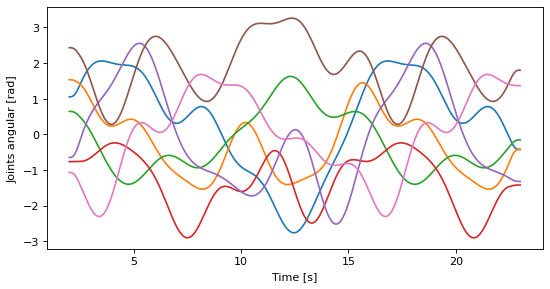

In [43]:
from workspace.ArtificialDataGenerator.file import trans_format, Convert_q

            
ref_time, ref_q0, ref_dq, ref_ddq = trans_format(1)
ref_q = Convert_q('traj1')

In [44]:
## add some noise to initial value
x_0 = np.concatenate([ref_q0.T, np.zeros([int(nx//2), 1])], axis=0)

In [45]:
Kp = np.array([17., 17., 17., 17., 10., 10., 10.]).reshape(-1,1)
Kd = np.array([7, 7, 5, 5, 5, 5, 5]).reshape(-1,1)
# Define the total steps to simulate
N_sim = len(ref_time)

In [71]:
# Define the input (for the moment consider u = 0)
u_k = np.zeros([7,1])

res_x_sundials = []
res_u = []

M_data = []
C_data = []
G_data = []

u_cmd_data = []

for i in tqdm(range(N_sim)):
    curr_q = x_0[:7]
    curr_dq = x_0[7:]
    error_q = curr_q - ref_q[i].reshape(7,1)
    error_dq = curr_dq - ref_dq[i].reshape(7,1)
    a_q = ref_ddq[i].reshape(7,1) - Kp*error_q - Kd*error_dq
    
    M_ = M_func(curr_q)
    C_ = C_func(np.concatenate([curr_q, curr_dq]))
    G_ = G_func(curr_q)
    C_ = C_@curr_q
    u_cmd = M_@a_q + C_
    u_k = u_cmd + G_
    
    M_data.append(M_.full().flatten()[:,np.newaxis])
    C_data.append(C_)
    G_data.append(G_)
    u_cmd_data.append(u_cmd)
    res_u.append(u_k)
    
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
    res_x_sundials.append(x_next)
    x_0 = x_next.full()


100%|██████████| 2101/2101 [00:16<00:00, 129.87it/s]


In [72]:
res_x_sundials = np.concatenate(res_x_sundials, axis=1)
res_u = np.concatenate(res_u, axis=1)
M_data = np.concatenate(M_data, axis=1)
C_data = np.concatenate(C_data, axis=1)
G_data = np.concatenate(G_data, axis=1)
u_cmd_data = np.concatenate(u_cmd_data, axis=1)

# PyDMDc

In [137]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy

from pydmd import DMDc

In [138]:
X = res_x_sundials

In [139]:
U = res_u[:, :-1]

In [140]:
dmdc = DMDc(svd_rank=10)

In [141]:
X.shape

(14, 2101)

In [142]:
dmdc.fit(X, U)

In [143]:
Xr = dmdc.reconstructed_data(U).real

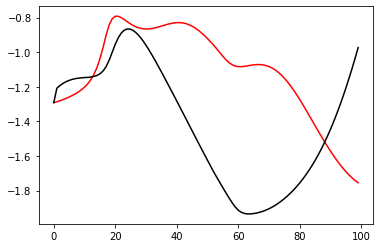

In [145]:
import matplotlib.pyplot as plt
plt.plot(X[3,:100], 'r-')
plt.plot(Xr[3,:100], 'k-')
plt.show()

### Neural networks control


In [10]:
from Controller import MPC, FiniteLQR

In [11]:
modelpath = '../Models/OfflineTrainingModels/Ep99_valiLoss_33127756.75/'

In [12]:
ABC = torch.load(modelpath + '/ABC.pth').to('cpu')
EnNet = torch.load(modelpath + '/EnNet.pth').to('cpu')
ABCweight = list(ABC.named_parameters())

LQR = FiniteLQR(ABCweight, N_sim)

In [35]:
Anew = ABCweight[0][1].detach().numpy()

In [13]:
Aold = ABCweight[0][1].detach().numpy()

In [37]:
np.linalg.norm(Aold-Anew)

0.0

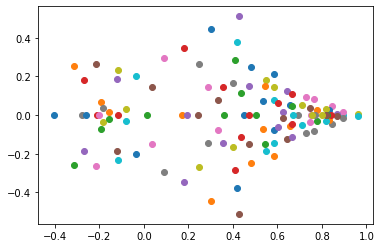

In [14]:
E,V = np.linalg.eig(Aold)
import matplotlib.pyplot as plt
for e in E:
    plt.scatter(e.real, e.imag)

### This neural network is able to run in about 10000 Hz

In [15]:
import time
start = time.time()
x_0_tensor = torch.from_numpy(x_0.T).float()
steps = 10000
for _ in range(steps):
    x_0_tensor_lifting = EnNet(x_0_tensor)
end = time.time()

print('Time consuming each step: ', (end-start) / steps )

Time consuming each step:  9.379603862762452e-05


### LQR

In [16]:
# Define the input (for the moment consider u = 0)
x_0 = np.concatenate([ref_q0.T, np.zeros([int(nx//2), 1])], axis=0) + np.random.randn(nx,1)*0.001

u_k = np.zeros([7,1])

res_x_LQR = [x_0]
res_u_LQR = [u_k]


for i in tqdm(range(N_sim)):
    xref = np.concatenate([ref_q[i], ref_dq[i]])[:, np.newaxis]
    xref = torch.from_numpy(xref).float().cpu()
    xref = EnNet(xref.T) # (1,70)
    
    xref = xref.cpu().detach().numpy()
    x_0_tensor = torch.from_numpy(x_0.T).float()
    with torch.no_grad():
        x_0_tensor_lifting = EnNet(x_0_tensor)

    x_0_lifting = x_0_tensor_lifting.cpu().detach().numpy() # (1,70)
    x_0_lifting = x_0_lifting.reshape(LQR.nx, 1)
    u_k = LQR(x_0_lifting, xref, i)
    #print(u_k)
    res_u_LQR.append(u_k)
    
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
    res_x_LQR.append(x_next)
    x_0 = x_next.full().reshape(LQR.nxx, 1)

  1%|          | 21/2101 [00:04<06:47,  5.11it/s]


RuntimeError: .../casadi/interfaces/sundials/idas_interface.cpp:591: IDASolve returned "IDA_TOO_MUCH_WORK". Consult IDAS documentation.

In [17]:
res_x_LQR = np.concatenate(res_x_LQR, axis=1)
res_u_LQR = np.concatenate(res_u_LQR, axis=1)

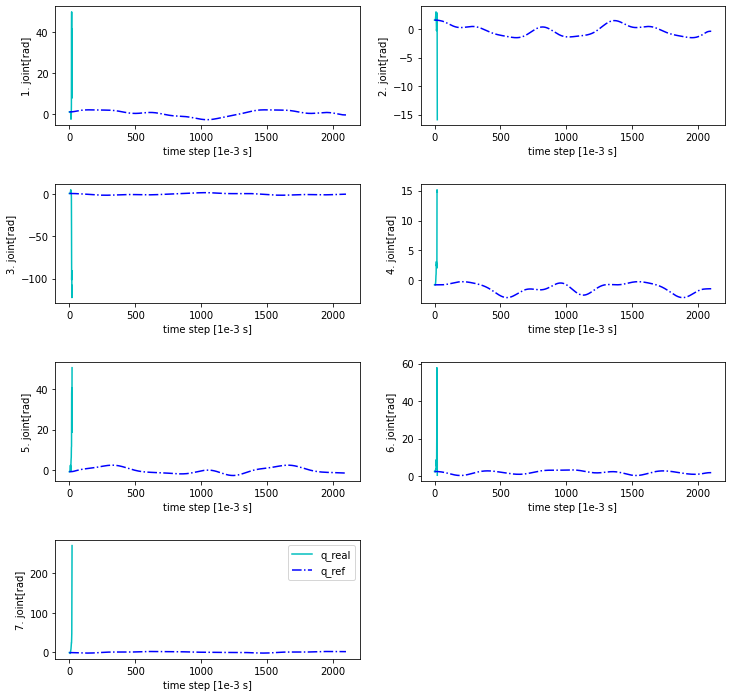

In [18]:
plt.figure(figsize=[12,12])

for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="time step [1e-3 s]", ylabel="{}. joint[rad]".format(channel+1))
    plt.plot(res_x_LQR[channel,:],'-c', label="q_real")
    plt.plot(ref_q[:,channel],'-.b', label="q_ref")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.legend()
plt.show()

### MPC

In [19]:
MPC = MPC(ABCweight)

SystemError: <built-in function nlpsol> returned a result with an error set

In [ ]:
# Define the input (for the moment consider u = 0)
x_0 = np.concatenate([ref_q0.T, np.zeros([int(nx//2), 1])], axis=0) + np.random.randn(nx,1)*0.001

u_k = np.zeros([7,1])

res_x_MPC = [x_0]
res_u_MPC = [u_k]


for i in tqdm(range(N_sim-MPC.N)):
    xref = np.concatenate([ref_q[i:i+MPC.N], ref_dq[i:i+MPC.N]], axis=1)

    x_0_tensor = torch.from_numpy(x_0.T).float()
    with torch.no_grad():
        x_0_tensor_lifting = EnNet(x_0_tensor)

    x_0_lifting = x_0_tensor_lifting.cpu().detach().numpy() # (1,70)
    x_0_lifting = x_0_lifting.reshape(MPC.nx, 1)
    u_k = MPC(x_0_lifting, xref, i)
    res_u_MPC.append(u_k)
    
    res_integrator = ode_solver(x0=x_0, p=u_k)
    x_next = res_integrator['xf']
    res_x_MPC.append(x_next)
    x_0 = x_next.full().reshape(MPC.nxx, 1)

In [45]:
res_x_MPC = np.concatenate(res_x_MPC, axis=1)
res_u_MPC = np.concatenate(res_u_MPC, axis=1)

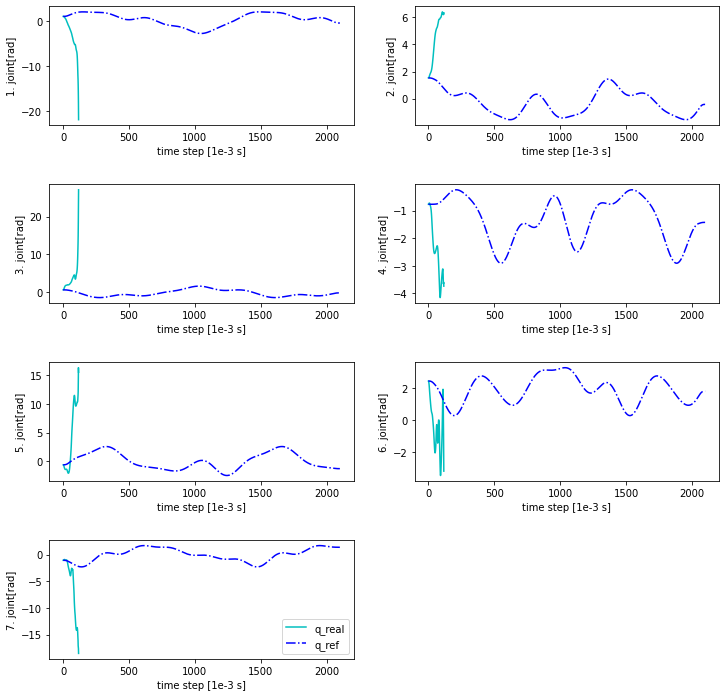

In [46]:
plt.figure(figsize=[12,12])

for channel in range(7):
    plt.subplot(4,2,channel+1,xlabel="time step [1e-3 s]", ylabel="{}. joint[rad]".format(channel+1))
    plt.plot(res_x_MPC[channel,:],'-c', label="q_real")
    plt.plot(ref_q[:,channel],'-.b', label="q_ref")
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.legend()
plt.show()